In [1]:
import os, sys
import yaml

cwd = os.getcwd()
sys.path.append(os.path.dirname(cwd))
from utils import models_classifyer as models
from utils import preprocessing as pre
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import seaborn as sns

models_weights = ["../weights/Model1/model1_weights.h5", "../weights/Model3/model3_weights.h5", "../weights/Model5/model5_weights.h5"]
names = ["model1", "model2", "model3"]
file = "../config/Classifier/config_classifier1.yaml"
with open(file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model_input = tf.keras.layers.Input(shape=(512,21))
model1 = models.Classifier_reg1(config['Classifier'], name = names[0])
model2 = models.Classifier_reg1(config['Classifier'], name = names[1])
model3 = models.Classifier_reg1(config['Classifier'], name = names[2])

output1 = model1(model_input)
output2 = model2(model_input)
output3 = model3(model_input)

model1.summary()

model1.load_weights("../weights/Model1/model1_weights.h5")
model2.load_weights("../weights/Model3/model3_weights.h5")
model3.load_weights("../weights/Model5/model5_weights.h5")


ensemble_output = tf.keras.layers.Average()([output1, output2, output3])
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.summary()
#model.load_weights("../weights/Model1/model1_weights.h5")

Model: "classifier_reg1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           12160     
_________________________________________________________________
res_mod_pre_act_sn (ResModPr (None, 512, 64)           78144     
_________________________________________________________________
res_mod_pre_act_sn_1 (ResMod (None, 256, 64)           115136    
_________________________________________________________________
res_mod_pre_act_sn_2 (ResMod (None, 128, 64)           115136    
_________________________________________________________________
res_mod_pre_act_sn_3 (ResMod (None, 128, 128)          230016    
_________________________________________________________________
res_mod_pre_act_sn_4 (ResMod (None, 64, 128)           459648    
_________________________________________________________________
res_mod_pre_act_sn_5 (ResMod (None, 32, 128)       

In [6]:
# VAL Load data

config["Data"]["base_dir"] = "../data"
config["Data"]["train_dir"] = "Combined_data/published/Groups_5/RECORDS_REG_GLOBAL/train/*.tfrecord"
config["Data"]["val_dir"] = "Combined_data/published/Groups_5/RECORDS_REG_GLOBAL/test/*.tfrecord"

_, data_val = pre.load_data(config["Data"])
data_val = [(i[0], i[1]) for i in data_val.batch(64).as_numpy_iterator()]

In [7]:
# Make predictions 
pairs = []
for samp in data_val:
    predict1 = ensemble_model.predict(samp[0])
    pairs.append([samp[1], predict1.reshape(-1)])

arr = np.zeros(shape=((len(pairs)-1)*64 + pairs[-1][1].shape[0],2))
for i, ele in enumerate(pairs):
    if i <len(pairs):
        arr[i*64:(i+1)*64,0] = ele[0]
        arr[i*64:(i+1)*64,1] = ele[1]
    else:
        arr[i*64:,0] = ele[0]
        arr[i*64:,1] = ele[1]

In [8]:
# Statistics

r = sklearn.metrics.r2_score(arr[:,0], arr[:,1])
print("R square {}  ".format(r))

R square -0.36867272048216226  


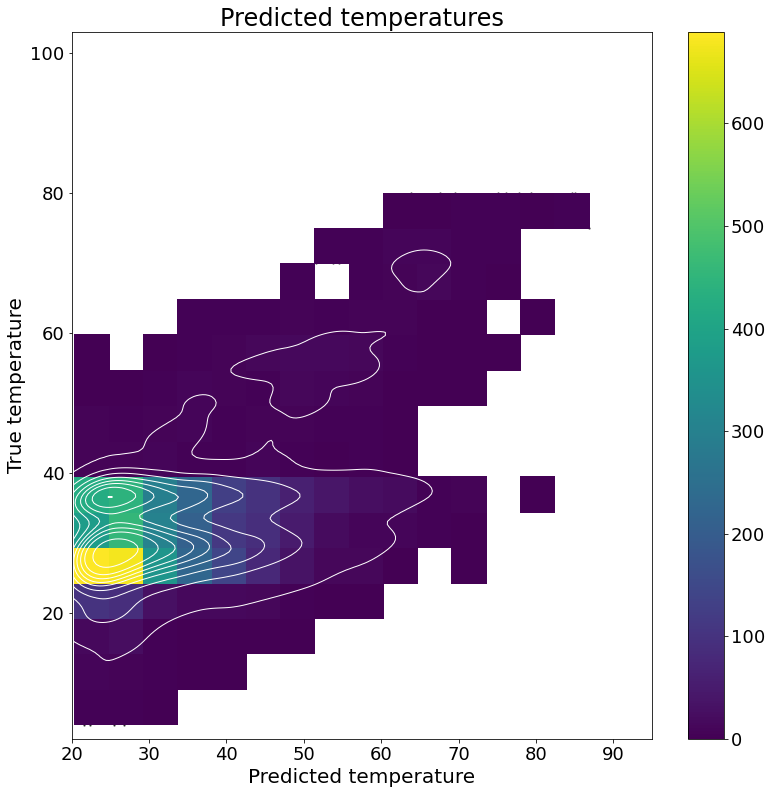

In [9]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x, y = arr[:,1], arr[:,0]
f, ax = plt.subplots(figsize=[13, 13])
sns.scatterplot(x=x, y=y, s=5, color=".15")

sns.histplot(x=x, y=y, bins=15,cmap="viridis", cbar = True, pmax = 0.9)
sns.kdeplot(x=x, y=y, levels=10, color="w", linewidths=1)
plt.xlim([20,95])
plt.ylim([2, 103])
plt.title("Predicted temperatures")
plt.xlabel("Predicted temperature")
plt.ylabel("True temperature")
plt.savefig("img_reg.png")